<a href="https://colab.research.google.com/github/Annie-Yeeun-Jang/Plant_disease_classification/blob/master/cam_resnet50_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image as pil_image
import cv2

import glob

import tensorflow as tf
from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras import backend as K
from tensorflow.python.framework import ops


import scipy
from scipy import ndimage
from skimage.measure import label, regionprops
from keras.models import load_model, model_from_json
%matplotlib inline

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
K.set_learning_phase(False)

In [7]:
## 1. load model
model = load_model("41-0.0443_halfFreeze.hdf5")

In [13]:
os.chdir('/content/gdrive/My Drive/')

In [140]:
## 2. image sources

path_c='/content/gdrive/My Drive/dataset_split_aug/test/'
class_indices=['Potato___healthy', 'Corn___healthy' , 'Tomato___healthy','Apple___healthy','Cherry___healthy']

In [143]:
samples=[{'class_idx': 0,
  'img_path': '/content/gdrive/My Drive/dataset_split_aug/test/Tomato___Septoria_leaf_spot/image (435).JPG',
  'target': 'Tomato___Septoria_leaf_spot'},
 {'class_idx': 1,
  'img_path': '/content/gdrive/My Drive/dataset_split_aug/test/Peach___Bacterial_spot/image (2289).JPG',
  'target': 'Peach___Bacterial_spot'},
 {'class_idx': 3,
  'img_path': '/content/gdrive/My Drive/dataset_split_aug/test/Apple___healthy/image (81).JPG',
  'target': 'Apple___healthy'},
 {'class_idx': 3,
  'img_path': '/content/gdrive/My Drive/dataset_split_aug/test/Pepper__bell___Bacterial_spot/image (989).JPG',
  'target': 'Pepper__bell___Bacterial_spot'},
 {'class_idx': 4,
  'img_path': '/content/gdrive/My Drive/dataset_split_aug/test/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (3334).JPG',
  'target': 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'}] #클래스 인덱스 0,1,3,4고정

In [37]:
def preprocess_input(img_path):
    img = pil_image.open(img_path).resize((224, 224))
    img_arr = np.asarray(img)[:, :, :3] / 255.
    img_tensor = np.expand_dims(img_arr, 0)
    
    return img_arr, img_tensor

In [38]:
def generate_cam(model, img_path, class_idx):
    
    ## img_path -> preprocessed image tensor
    img_arr, img_tensor = preprocess_input(img_path)
    
    ## preprocessed image tensor -> last_conv_output, predictions
    get_output = K.function([model.layers[0].input], [model.layers[-4].output, model.layers[-1].output])
    [conv_outputs, predictions] = get_output([img_tensor])
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0]
    
    ## generate cam
    cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        cam += w * conv_outputs[:, :, i]
        
    cam /= np.max(cam)
    cam = cv2.resize(cam, (224, 224))
    
    return img_arr, cam, predictions    

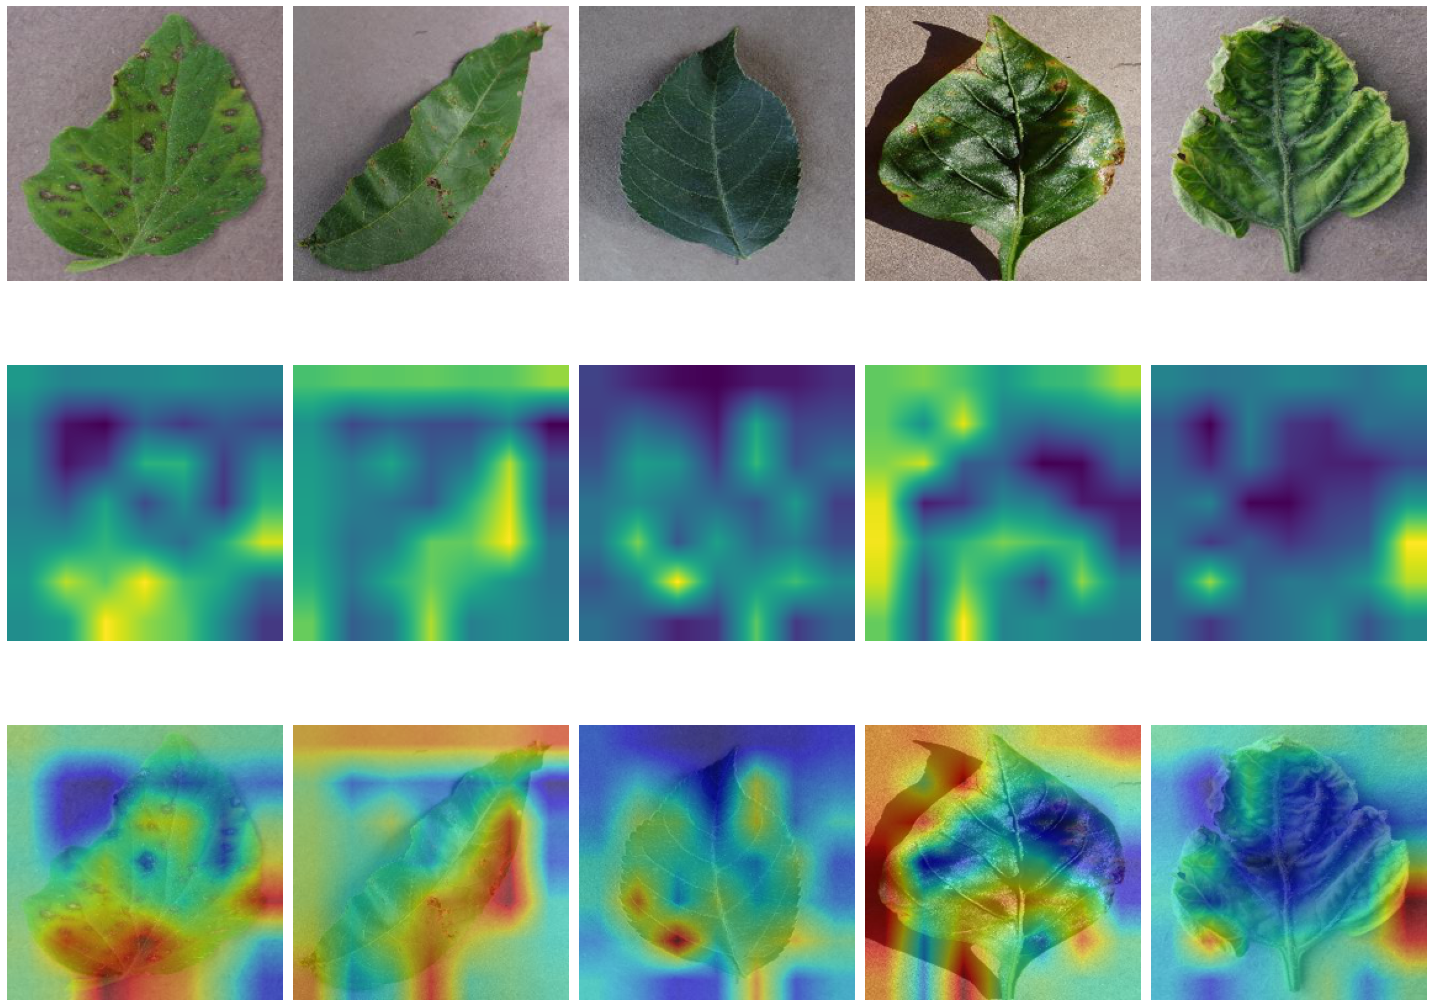

In [144]:
#CAM
fig, axes = plt.subplots(3, 5, figsize=(20, 16))

for i, s in enumerate(samples):
    img_set = s['target']
    img_path = s['img_path']
    class_idx = s['class_idx']
    img, cam, predictions = generate_cam(model, img_path, class_idx)
    pred_values = np.squeeze(predictions, 0)
    #top1 = np.argmax(pred_values)
    top1_value = round(float(pred_values[top1]), 3)
    props = generate_bbox(img, cam, 0.2)
    
    axes[0, i].imshow(img)
    axes[1, i].imshow(cam)
    axes[2, i].imshow(img)
    axes[2, i].imshow(cam, cmap='jet', alpha=0.5)
    
   # axes[3, i].imshow(img)
    '''
    for b in props:
        bbox = b.bbox
        xs = bbox[1]
        ys = bbox[0]
        w = bbox[3] - bbox[1]
        h = bbox[2] - bbox[0]

        rect = patches.Rectangle((xs, ys), w, h, linewidth=2, edgecolor='r', facecolor='none')
        axes[3, i].add_patch(rect)
    '''
    axes[0,i].axis('off')
    axes[1,i].axis('off')
    axes[2,i].axis('off')
  #  axes[3,i].axis('off')
    
    #axes[0, i].set_title("pred: {} - {}".format(class_indices[top1], top1_value), fontsize=15)
    
plt.tight_layout()
plt.show()